CNN Modelling

In [ ]:
#Importing the required libraries
import pandas as pd
import numpy as np
import nltk

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping

from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#Loading the dataset
Preprocessed_df= pd.read_csv('/content/Preprocessed_data_.csv')
Preprocessed_df.tail()

,Unnamed: 0,text,original_text,listed_emotions,emotion_count,labels,encoded_labels
55863,55863,‪still havent lost row still havent lost leading,"‪Still haven’t lost 3 in a row, Still haven’t ...",neutral,1,neutral,1
55864,55864,♪… without baby still lonely mind think baby d...,*♪… I'm here without you baby But you're still...,"caring, love",2,positive,2
55865,55865,♫ love quite take whiff hershey stain ♫,♫ Your love for me Won't be quite the same Whe...,love,1,positive,2
55866,55866,카니발 sound like cannibal carnival,카니발 sounds more like cannibal than carnival.,fear,1,negative,0
55867,55867,ﾉωﾉ okay senpai owo nuzzles frick write whatev...,(*ﾉωﾉ) O-okay senpai OWO *Nuzzles* Frick off I...,neutral,1,neutral,1


In [ ]:
#Classifying the text and encoded_labels
text_label = Preprocessed_df[['text','encoded_labels']]
text_label.head()

,text,encoded_labels
0,aa b whole meritocracy gtfo,1
1,aaaaaaaaaaaaaahhh imagine,1
2,aaaaaaaaaaaaand boop,0
3,aaaaaand feeling morning,1
4,aaaaaand soccer hopefully,1


In [ ]:
text_label.encoded_labels.unique()

array([1, 0, 2])

In [ ]:
#Converting the 'text' column to strings
text_label['text'] = text_label['text'].astype(str)

#Performing lemmatization on the cleaned text column
# Create an instance of WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Function to apply lemmatization to a list of words
def apply_lemmatization(word_list):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in word_list] #lemmatize each word
    lemmatized_text = ' '.join(['[' + lemmatizer.lemmatize(word) + ']' for word in word_list]) #Joining lemmatized words
    return lemmatized_text

# Create a new column 'lemmatized_column' with the lemmatized text
text_label['lemmatized_column'] = text_label['text'].apply(lambda text: apply_lemmatization(word_tokenize(text)))

# Print the updated DataFrame
print(text_label)

                                                    text  encoded_labels  \
0                            aa b whole meritocracy gtfo               1   
1                              aaaaaaaaaaaaaahhh imagine               1   
2                                   aaaaaaaaaaaaand boop               0   
3                               aaaaaand feeling morning               1   
4                              aaaaaand soccer hopefully               1   
...                                                  ...             ...   
55863   ‪still havent lost row still havent lost leading               1   
55864  ♪… without baby still lonely mind think baby d...               2   
55865            ♫ love quite take whiff hershey stain ♫               2   
55866                   카니발 sound like cannibal carnival               0   
55867  ﾉωﾉ okay senpai owo nuzzles frick write whatev...               1   

                                       lemmatized_column  
0                  [aa] [b] 

In [ ]:
#Creating a new dataframe with the lemmatized column and encoded labels
text_label_1  = text_label[['lemmatized_column','encoded_labels']]
text_label_1.head()

,lemmatized_column,encoded_labels
0,[aa] [b] [whole] [meritocracy] [gtfo],1
1,[aaaaaaaaaaaaaahhh] [imagine],1
2,[aaaaaaaaaaaaand] [boop],0
3,[aaaaaand] [feeling] [morning],1
4,[aaaaaand] [soccer] [hopefully],1


In [ ]:
#Performing tokenisation and train test splits on the lemmatized_column and encoded_labels

# Batch Processing Configuration
batch_size = 1000

# Tokenization and Data Preparation
# Tokenization
tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary size to the most frequent 5000 words
tokenizer.fit_on_texts(text_label_1['lemmatized_column'])  # Fit the tokenizer on lemmatized text
word_index = tokenizer.word_index  # Get the word index

# Convert text to sequences of integers in batches
sequences = []
for i in range(0, len(text_label_1), batch_size):
    batch_texts = text_label['lemmatized_column'][i:i + batch_size].tolist()
    batch_sequences = tokenizer.texts_to_sequences(batch_texts)
    sequences.extend(batch_sequences)

# Padding sequences to a fixed length
max_sequence_length = max(len(sequence) for sequence in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Convert encoded_labels to numpy array
labels = np.array(text_label_1['encoded_labels'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Print the shapes of train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (44694, 25)
X_test shape: (11174, 25)
y_train shape: (44694,)
y_test shape: (11174,)


In [ ]:
# @title

vocab_size = len(word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(4, activation='softmax'))  # Four units for four classes, using softmax activation

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert labels to one-hot encoded format
one_hot_labels = to_categorical(labels, num_classes=4)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

# Print the shapes of train and test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
epochs = 10
batch_size = 32

#Fitting the model
model.fit(X_train, one_hot_labels, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

# Evaluation on test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


'vocab_size = len(word_index) + 1\n\nmodel = Sequential()\nmodel.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))\nmodel.add(Conv1D(128, 5, activation=\'relu\'))\nmodel.add(GlobalMaxPooling1D())\nmodel.add(Dense(4, activation=\'softmax\'))  # Four units for four classes, using softmax activation\n\nmodel.compile(loss=\'categorical_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n\n# Convert labels to one-hot encoded format\none_hot_labels = to_categorical(labels, num_classes=4)\n\n# Train-Test Split\nX_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)\n\n# Print the shapes of train and test sets\nprint("X_train shape:", X_train.shape)\nprint("X_test shape:", X_test.shape)\nprint("y_train shape:", y_train.shape)\nprint("y_test shape:", y_test.shape)\n\n# Early Stopping\nearly_stopping = EarlyStopping(monitor=\'val_loss\', patience=3, restore_best_weights=True)\n\

The results obtained are as shown



*  X_train shape: (166251, 21)
*  X_test shape: (41563, 21)
*  y_train shape: (166251, 4)
*  y_test shape: (41563, 4)

*   Epoch 1/10 val_loss: 1.2233 - val_accuracy: 0.4196
*   Epoch 2/10 val_loss: 1.2425 - val_accuracy: 0.3805
*   Epoch 3/10 val_loss: 1.2746 - val_accuracy: 0.3959
*   Epoch 4/10 val_loss: 1.3088 - val_accuracy: 0.3705


Test Loss: 1.2232732772827148
Test Accuracy: 0.4179438352584839

In [ ]:
#Padding using a word index length and adding 1 for the padding sequence
vocab_size = len(word_index) + 1
embedding_dim = 100

# Convert labels to one-hot encoded format
one_hot_labels = to_categorical(labels, num_classes=4)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

# Define a range of epochs and batch sizes to iterate over
epochs_range = range(1, 11)
batch_sizes = [32,64,128]

#Creating a nested loop to iterate through all the epochs range and batch sizes
for batch_size in batch_sizes:
    for epochs in epochs_range:
        print(f"Training model with batch size = {batch_size}, epochs = {epochs}")

        model = Sequential()
        model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
        model.add(Conv1D(128, 5, activation='relu'))
        model.add(GlobalMaxPooling1D())
        model.add(Dense(4, activation='softmax'))  # Four units for four classes, using softmax activation

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Early Stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Fitting the model
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping])

        # Evaluation on test set
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f"Test Loss (epochs={epochs}, batch_size={batch_size}):", loss)
        print(f"Test Accuracy (epochs={epochs}, batch_size={batch_size}):", accuracy)


Training model with batch size = 32, epochs = 1
350/350 [==============================] - 2s 4ms/step - loss: 0.9031 - accuracy: 0.5722
Test Loss (epochs=1, batch_size=32): 0.9031403064727783
Test Accuracy (epochs=1, batch_size=32): 0.5722212195396423
Training model with batch size = 32, epochs = 2
Epoch 1/2
1257/1257 [==============================] - 70s 55ms/step - loss: 0.9383 - accuracy: 0.5471 - val_loss: 0.8847 - val_accuracy: 0.5886
Epoch 2/2
350/350 [==============================] - 1s 4ms/step - loss: 0.9204 - accuracy: 0.5715
Test Loss (epochs=2, batch_size=32): 0.9203854203224182
Test Accuracy (epochs=2, batch_size=32): 0.5715053081512451
Training model with batch size = 32, epochs = 3
Epoch 1/3
1257/1257 [==============================] - 66s 52ms/step - loss: 0.9354 - accuracy: 0.5511 - val_loss: 0.8855 - val_accuracy: 0.5823
Epoch 2/3
1257/1257 [==============================] - 62s 49ms/step - loss: 0.8129 - accuracy: 0.6380 - val_loss: 0.9133 - val_accuracy: 0.5736
E

In [ ]:
#The ouptuts for the different iterations are shown below

Training model with batch size = 32, epochs = 1
1257/1257 - val_loss: 0.8990 - val_accuracy: 0.5852
---
Epoch 2/2
1257/1257 - val_loss: 0.9082 - val_accuracy: 0.5823
---
Epoch 3/3
1257/1257 - val_loss: 1.0122 - val_accuracy: 0.5579
---
Epoch 4/4
1257/1257 - val_loss: 1.2507 - val_accuracy: 0.5383
---
Epoch 5/5
1257/1257 - val_loss: 1.5028 - val_accuracy: 0.5324
---
Epoch 6/6
1257/1257 - val_loss: 1.8083 - val_accuracy: 0.5170
---
Epoch 7/7
1257/1257 - val_loss: 2.0688 - val_accuracy: 0.5197
---
Epoch 8/8
1257/1257 - val_loss: 2.4757 - val_accuracy: 0.5085
---
Epoch 9/9
1257/1257 - val_loss: 2.6693 - val_accuracy: 0.5154
---
Epoch 10/10
1257/1257 - val_loss: 2.9806 - val_accuracy: 0.5143
---
Training model with batch size = 64, epochs = 2
---
Epoch 2/2
629/629 - val_loss: 0.8993 - val_accuracy: 0.5785
---
Epoch 3/3
629/629 - val_loss: 0.9792 - val_accuracy: 0.5579
---
Epoch 4/4
629/629 - val_loss: 1.1611 - val_accuracy: 0.5479
---
Epoch 5/5
629/629 - val_loss: 1.3398 - val_accuracy: 0.5365
---
Epoch 6/6
629/629 - val_loss: 1.6142 - val_accuracy: 0.5219
---
Epoch 7/7
629/629 - val_loss: 1.8902 - val_accuracy: 0.5186
---
Epoch 8/8
629/629 - val_loss: 2.1048 - val_accuracy: 0.5174
---
Epoch 9/9
629/629 - val_loss: 2.3445 - val_accuracy: 0.5067
---
Epoch 10/10
629/629 - val_loss: 2.5957 - val_accuracy: 0.5105
---
Test Accuracy (epochs=2, batch_size=128): 0.5784857869148254
Training model with batch size = 128, epochs = 3
---
Epoch 3/3
315/315 - val_loss: 0.9566 - val_accuracy: 0.5631
---
Epoch 4/4
315/315 - val_loss: 1.0425 - val_accuracy: 0.5488
---
Epoch 5/5
315/315 - val_loss: 1.1965 - val_accuracy: 0.5353
---
Epoch 6/6
315/315 - val_loss: 1.3681 - val_accuracy: 0.5327
---
Epoch 7/7
315/315 - val_loss: 1.5901 - val_accuracy: 0.5215
---
Epoch 8/8
315/315 - val_loss: 1.7862 - val_accuracy: 0.5154
---
Epoch 9/9
315/315 - val_loss: 2.0162 - val_accuracy: 0.5161
---
Epoch 10/10
315/315 - val_loss: 2.1622 - val_accuracy: 0.5161
---
Test Loss (epochs=10, batch_size=128): 2.202045440673828
---
Epoch 2/2
1257/1257 - val_loss: 0.9082 - val_accuracy: 0.5823
---
Epoch 3/3
1257/1257 - val_loss: 1.0122 - val_accuracy: 0.5579
---
Epoch 4/4
1257/1257 - val_loss: 1.2507 - val_accuracy: 0.5383
---
Epoch 5/5
1257/1257 - val_loss: 1.5028 - val_accuracy: 0.5324
---
Epoch 6/6
1257/1257 - val_loss: 1.8083 - val_accuracy: 0.5170
---
Epoch 7/7
1257/1257 - val_loss: 2.0688 - val_accuracy: 0.5197
---
Epoch 8/8
1257/1257 - val_loss: 2.4757 - val_accuracy: 0.5085
---
Epoch 9/9
1257/1257 - val_loss: 2.6693 - val_accuracy: 0.5154
---
Epoch 10/10
1257/1257 - val_loss: 2.9806 - val_accuracy: 0.5143


Training model with batch size = 64, epochs = 1 - val_loss: 0.9967 - val_accuracy: 0.5742

---
Epoch 1/2 - val_loss: 1.0030 - val_accuracy: 0.5717
---
Epoch 2/2- val_loss: 1.0048 - val_accuracy: 0.5736
---
Epoch 3/3- val_loss: 1.0159 - val_accuracy: 0.5713
---
Epoch 4/4 - val_loss: 1.0430 - val_accuracy: 0.5747
---
Epoch 5/5 - val_loss: 1.0548 - val_accuracy: 0.5715
---
Epoch 6/6 - val_loss: 1.0853 - val_accuracy: 0.5704
---
Epoch 7/7 - val_loss: 1.1043 - val_accuracy: 0.5672
---
Epoch 8/8 - val_loss: 1.1107 - val_accuracy: 0.5688
---
Epoch 9/9 - val_loss: 1.1271 - val_accuracy: 0.5611
---
Epoch 10/10 - val_loss: 1.1398 - val_accuracy: 0.5651
---


Training model with batch size = 128, epochs = 1 - val_loss: 0.9952 - val_accuracy: 0.5721
---
Epoch 1/2 - val_loss: 0.9957 - val_accuracy: 0.5721
---
Epoch 2/2 - val_loss: 0.9969 - val_accuracy: 0.5776
---
Epoch 3/3 - val_loss: 1.0125 - val_accuracy: 0.5777
---
Epoch 4/4 - val_loss: 1.0340 - val_accuracy: 0.5735
---
Epoch 5/5 - val_loss: 1.0591 - val_accuracy: 0.5675
---
Epoch 6/6 - val_loss: 1.0886 - val_accuracy: 0.5697
---
Epoch 7/7 - val_loss: 1.1018 - val_accuracy: 0.5704
---
Epoch 8/8 - val_loss: 1.1190 - val_accuracy: 0.5684
---
Epoch 9/9 - val_loss: 1.1361 - val_accuracy: 0.5678
---
Epoch 10/10 - val_loss: 1.1496 - val_accuracy: 0.5654
---
Test Loss (epochs=10, batch_size=128): 1.1456750631332397
Test Accuracy (epochs=10, batch_size=128): 0.5665375590324402

Performing Hyper Parameter tuning for the above model using: -


*   5 random iterations of hyperparameter combinations
*   3 fold cross validation





In [ ]:
# Define the CNN model function
def create_cnn_model(num_filters=128, dense_size=128):
    model = Sequential()
    model.add(Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, input_length=max_sequence_length))
    model.add(Conv1D(num_filters, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Four units for four classes, using softmax activation

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create KerasClassifier for RandomizedSearchCV
model = KerasClassifier(build_fn=create_cnn_model, verbose=0)

# Define hyperparameter grid for Random Search
param_grid = {
    'num_filters': [64, 128, 256],
    'dense_size': [64, 128, 256]
}

# Perform Random Search with 3-fold cross-validation
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=5, cv=3, verbose=2)
random_search_result = random_search.fit(padded_sequences, one_hot_labels)

# Print the best hyperparameters and their corresponding accuracy
print("Best Hyperparameters: ", random_search_result.best_params_)
print("Best Accuracy: ", random_search_result.best_score_)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ....................dense_size=256, num_filters=256; total time= 1.5min
[CV] END ....................dense_size=256, num_filters=256; total time= 1.5min
[CV] END ....................dense_size=256, num_filters=256; total time= 1.5min
[CV] END .....................dense_size=128, num_filters=64; total time= 1.4min
[CV] END .....................dense_size=128, num_filters=64; total time= 1.4min
[CV] END .....................dense_size=128, num_filters=64; total time=  50.3s
[CV] END .....................dense_size=64, num_filters=256; total time= 1.5min
[CV] END .....................dense_size=64, num_filters=256; total time= 1.5min
[CV] END .....................dense_size=64, num_filters=256; total time= 1.3min
[CV] END .....................dense_size=256, num_filters=64; total time= 1.4min
[CV] END .....................dense_size=256, num_filters=64; total time= 1.4min
[CV] END .....................dense_size=256, num

The following are the best hyperparameters obtained
---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
---
[CV] END ....................dense_size=256, num_filters=256; total time= 1.5min
---
[CV] END ....................dense_size=256, num_filters=256; total time= 1.5min
---
[CV] END ....................dense_size=256, num_filters=256; total time= 1.5min
---
[CV] END .....................dense_size=128, num_filters=64; total time= 1.4min
---
[CV] END .....................dense_size=128, num_filters=64; total time= 1.4min
---
[CV] END .....................dense_size=128, num_filters=64; total time=  50.3s
---
[CV] END .....................dense_size=64, num_filters=256; total time= 1.5min
---
[CV] END .....................dense_size=64, num_filters=256; total time= 1.5min
---
[CV] END .....................dense_size=64, num_filters=256; total time= 1.3min
---
[CV] END .....................dense_size=256, num_filters=64; total time= 1.4min
---
[CV] END .....................dense_size=256, num_filters=64; total time= 1.4min
---
[CV] END .....................dense_size=256, num_filters=64; total time= 1.4min
---
[CV] END ....................dense_size=128, num_filters=256; total time= 1.2min
---
[CV] END ....................dense_size=128, num_filters=256; total time= 1.4min
---
[CV] END ....................dense_size=128, num_filters=256; total time= 1.5min
---
Best Hyperparameters:  {'num_filters': 256, 'dense_size': 256}
Best Accuracy:  0.579007605711619





In [ ]:
#Including the best num_filters and dense_size of 256
from sklearn.metrics import confusion_matrix

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)

best_model = create_cnn_model(num_filters=256, dense_size=256)  # Use the best parameters

# Training the model on the training set
best_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1, verbose=1)

# Making predictions on the test set
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert predicted probabilities to class labels

# Converting the one-hot encoded test labels back to integer labels
y_test_labels = np.argmax(y_test, axis=1)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

print("Confusion Matrix:")
print(conf_matrix)



Epoch 1/10
315/315 [==============================] - 46s 140ms/step - loss: 0.9559 - accuracy: 0.5348 - val_loss: 0.8865 - val_accuracy: 0.5899
Epoch 2/10
315/315 [==============================] - 42s 135ms/step - loss: 0.8293 - accuracy: 0.6272 - val_loss: 0.9053 - val_accuracy: 0.5832
Epoch 3/10
315/315 [==============================] - 44s 140ms/step - loss: 0.6961 - accuracy: 0.7077 - val_loss: 0.9937 - val_accuracy: 0.5613
Epoch 4/10
315/315 [==============================] - 44s 138ms/step - loss: 0.4858 - accuracy: 0.8123 - val_loss: 1.1969 - val_accuracy: 0.5481
Epoch 5/10
315/315 [==============================] - 43s 138ms/step - loss: 0.2905 - accuracy: 0.8926 - val_loss: 1.5867 - val_accuracy: 0.5398
Epoch 6/10
315/315 [==============================] - 43s 137ms/step - loss: 0.1794 - accuracy: 0.9358 - val_loss: 2.0172 - val_accuracy: 0.5239
Epoch 7/10
315/315 [==============================] - 42s 134ms/step - loss: 0.1232 - accuracy: 0.9560 - val_loss: 2.4043 - val_ac

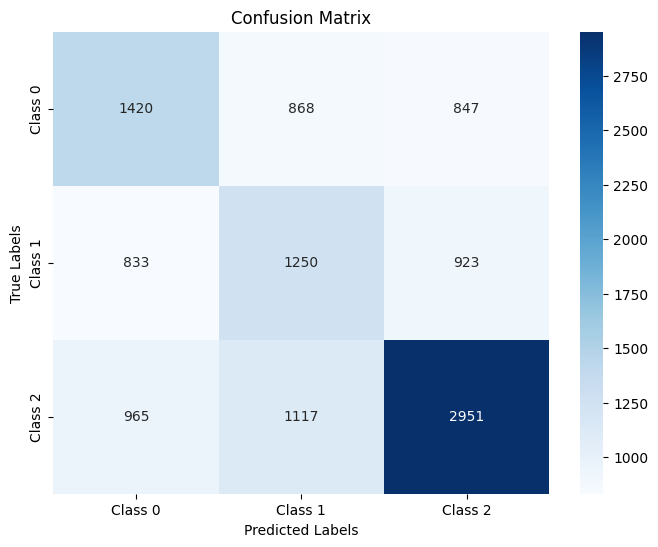

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)

# Plotting the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Class Negative (Actual) vs. Class Negative (Predicted): 1420 true positives (TP)
---
Class Negative (Actual) vs. Class Neutral (Predicted): 868 false positives (FP)
---
Class Negative (Actual) vs. Class Positive (Predicted): 847 false negatives (FN)
---
Class Neutral (Actual) vs. Class Negative (Predicted): 833 false negatives (FN)
---
Class Neutral (Actual) vs. Class Neutral (Predicted): 1250 true positives (TP)
---
Class Neutral (Actual) vs. Class Positive (Predicted): 923 false positives (FP)
---
Class Positive (Actual) vs. Class Negative (Predicted): 965 false negatives (FN)
---
Class Positive (Actual) vs. Class Neutral (Predicted): 1117 false positives (FP)
---
Class Positive (Actual) vs. Class Positive (Predicted): 2951 true positives (TP)
---



Epoch 1/30
315/315 [==============================] - 44s 138ms/step - loss: 0.0795 - accuracy: 0.9698 - val_loss: 4.1090 - val_accuracy: 0.5119
Epoch 2/30
315/315 [==============================] - 43s 137ms/step - loss: 0.0475 - accuracy: 0.9809 - val_loss: 4.7449 - val_accuracy: 0.5107
Epoch 3/30
315/315 [==============================] - 43s 136ms/step - loss: 0.0329 - accuracy: 0.9858 - val_loss: 5.1581 - val_accuracy: 0.5136
Epoch 4/30
315/315 [==============================] - 42s 134ms/step - loss: 0.0298 - accuracy: 0.9871 - val_loss: 5.4523 - val_accuracy: 0.5168
Epoch 5/30
315/315 [==============================] - 42s 134ms/step - loss: 0.0280 - accuracy: 0.9871 - val_loss: 5.6551 - val_accuracy: 0.5065
Epoch 6/30
315/315 [==============================] - 43s 137ms/step - loss: 0.0265 - accuracy: 0.9880 - val_loss: 5.6879 - val_accuracy: 0.5087
Epoch 7/30
315/315 [==============================] - 43s 138ms/step - loss: 0.0260 - accuracy: 0.9877 - val_loss: 5.8296 - val_ac

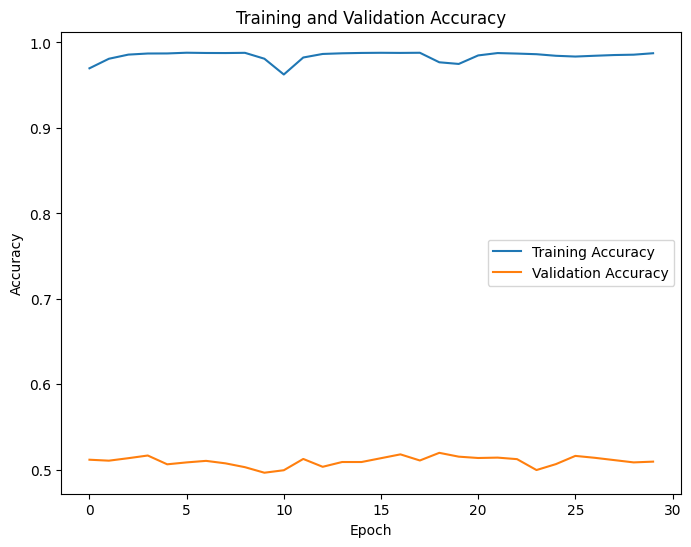

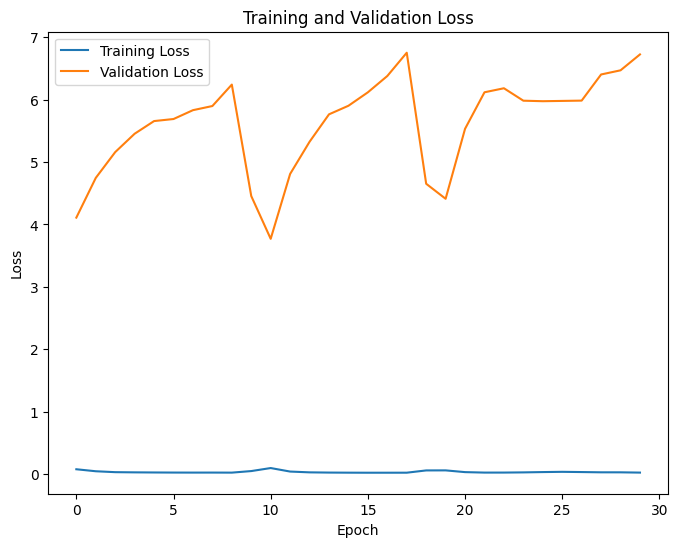

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'best_model' is the trained CNN model
import matplotlib.pyplot as plt

# Assuming 'best_model' is the trained CNN model

# Training the model on the training set and getting the training history
history = best_model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.1, verbose=1)

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()





**Displaying the performace metrics**

Precision -0.6656

---


Recall - 0.6102

---



---


F1 Score - 0.6377
